In [2]:
import numpy as np
import matplotlib.pyplot as plt

class March:
    def __init__(self,b=None,r=None,bk=None,rk=None):
        if b == None:
            self.b = sum([1 << i for i in range(41, 47)]) + sum([1 << i for i in range(49, 55)])
        else:
            self.b = b
        if r == None:
            self.r = sum([1 << i for i in range(9, 15)]) + sum([1 << i for i in range(17, 23)])
        else:
            self.r = r
        if bk == None:
            self.bk = 1 << 52
        else:
            self.bk = bk
        if rk == None:
            self.rk = 1 << 11
        else:
            self.rk = rk
        self.b = (self.b | self.bk)
        self.r = (self.r | self.rk)
        self.wall = sum([1 << i for i in range(0,8)]) | sum([1 << i for i in range(56,64)]) | sum([1 << i for i in range(0,64,8)]) | sum([1 << i for i in range(7,64,8)])   

    def __str__(self):
        s = "" 
        for y in range(8):
            for x in range(8):
                address = 8*y+x
                bit = 1<<address
                if self.bk & bit != 0 :
                    s += "O"
                elif self.rk & bit != 0:
                    s += "X"
                elif self.b & bit != 0:
                    s += "o"
                elif self.r & bit != 0:
                    s += "x"
                elif self.wall & bit != 0:
                    s += "#"
                else:
                    s += "."
                s += " "
            s += "\n"
        return s
    
    def reverseBoard(self):
        self.bk, self.rk = reverse64bit(self.rk), reverse64bit(self.bk)
        self.b, self.r = reverse64bit(self.r), reverse64bit(self.b)
        self.wall = reverse64bit(self.wall)
    
    def judge(self):
        if self.bk == 0:
            return -1
        if self.rk == 0:
            return 1
        blue_goal = (1<<15)-(1<<9) # sum([1 << i for i in range(9, 15)])
        red_goal = (1<<55)-(1<<49) # sum([1 << i for i in range(49, 55)])
        if self.bk & blue_goal != 0:
            return 1
        if self.rk & red_goal != 0:
            return -1
        if not self.existsChildren():
            return -1
        return 0
    
    def richJudge(self):
        #そもそも勝負がついている場合
        j = self.judge()
        if j != 0:
            return j 
        
        #王手をかけている場合
        for i in range(7, 10):
            if (self.rk<<i)&self.b != 0:
                return 1 
            
        #次で必ずゴールできる場合
        blue_sub_goal = (1<<23)-(1<<17) # sum([1 << i for i in range(17, 23)])
        if self.bk & blue_sub_goal != 0:
            return 1 
        
        return 0
    
    def existsChildren(self):
        for i in range(7, 10):
            if (self.b>>i) & ~(self.b|self.wall) != 0:
                return True
        return False
    
    def tos(self, frm):
        assert self.b & frm != 0
        tos = []
        for i in range(7,10):
            to = frm>>i
            if (to & self.wall == 0) and (to & self.b == 0):
                tos.append(to)
        return tos
        
    def move(self, move):
        self.b = self.b ^ move
        if self.bk & move != 0:
            self.bk = self.bk ^ move
        self.r = self.r & ~move
        self.rk = self.rk & ~move
        self.reverseBoard()
    
    def movable(self, frm, to):
        if self.b & frm == 0:
            return False
        if to & self.wall != 0:
            return False
        if to & self.b != 0:
            return False
        for i in range(7,10):
            if to == frm>>i:
                return True
        return False
    
    def children(self):
        children = []
        for i in range(64):
            frm = 1<<i
            if frm & self.b != 0:
                for to in self.tos(frm):
                    child = March(self.b, self.r, self.bk, self.rk)
                    child.move(frm^to)
                    children.append(child)
        return children

def bitprint(bit,name="    ",num=None):
    print(name,(num if num != None else " "),bin(bit).zfill(66))

def bitlist(bit):
    lst = []
    for i in range(64):
        if bit&(1<<i) != 0:
            lst.append(i)
    return lst
    
def reverse64bit(bit):
    ones = (1<<64)-1
    mask = lambda x: ones//((1<<(1<<x))+1)
    for i in range(6): # 2**6 = 64
        a = bit &  mask(i)
        b = bit & ~mask(i)
        bit = (a<<(1<<i))|(b>>(1<<i))
    return bit


def bitToVec(bit, bit_size = 64):
    return ((bit>>np.arange(bit_size, dtype="uint64"))%2).astype(np.int)

def showmap():
    s = ""
    for y in range(8):
        for x in range(8):
            s += str(8*y+x).zfill(2)+" "
        s += "\n"
    print(s)

def randomAI(march):
    while True:
        frm = 1<<np.random.randint(64)
        to = frm>>(9-np.random.randint(3))
        if march.movable(frm, to):
            return frm, to
        
def singleCalculationAI(march):
    for i in range(9,55):
        frm = 1<<i
        if frm & march.b != 0:
            for to in march.tos(frm):
                child = March(march.b, march.r, march.bk, march.rk)
                child.move(frm^to)
                if child.judge() == -1:
                    return (frm, to) 
    return randomAI(march)

class vanillaAI:
    def __init__(self, hidden_size = 50, filename = None):
        self.hidden_size = hidden_size
        self.W1 = np.random.randn(self.hidden_size, 256)/np.sqrt(256)
        self.W2 = np.random.randn(1, self.hidden_size)/np.sqrt(hidden_size)
        if filename:
            self.W1 = np.loadtxt(filename+"W1.csv", delimiter=',').reshape(self.hidden_size, 256)
            self.W2 = np.loadtxt(filename+"W2.csv", delimiter=',').reshape(1, self.hidden_size)
        self.h1 = np.zeros(self.W1.shape)
        self.h2 = np.zeros(self.W2.shape)
        self.record_x = []
        self.record_y = []
        
    def saveAI(self, filename, AdaGrad=False):
        np.savetxt(filename+"W1.csv", self.W1, delimiter=',')
        np.savetxt(filename+"W2.csv", self.W2, delimiter=',')
        np.savetxt(filename+"h1.csv", self.h1, delimiter=',')
        np.savetxt(filename+"h2.csv", self.h2, delimiter=',')
        
            
    def move(self, march, recording=True, showeval = False, epsilon=0.001):
        bestmove = None
        besteval = -float("inf") # Negamax法で、自分の勝率(1-eval)に直してしまう。
        for i in range(9,55):
            frm = 1<<i
            if frm & march.b != 0:
                for to in march.tos(frm):
                    child = March(march.b, march.r, march.bk, march.rk)
                    child.move(frm^to)
                    j = child.richJudge()
                    if j == 1:
                        thiseval = 0
                    elif j == -1:
                        thiseval = 1
                    else:
                        thiseval = (1-epsilon)-self.evaluate(child)[0,0]*(1-2*epsilon)
                    if thiseval == besteval and showeval:
                        print("衝突")
                        print("best:", bestmove, besteval)
                        print("this:", (frm, to), thiseval)
                    if thiseval >= besteval:
                        besteval = thiseval
                        bestmove = (frm, to)
        if recording:
            self.record_x.append(self.boardToOnehotLabel(march))
            self.record_y.append(besteval)
        if showeval:
            print("私の勝率は{0:.1f}%".format((besteval)*100))
        assert bestmove != None, "bestmoveはNoneであってはいけません。"
        return bestmove
            
    def think(self, march):
        pass
        

        
    def boardToOnehotLabel(self, march):
        b = bitToVec(march.b).reshape(64, 1)
        r = bitToVec(march.r).reshape(64, 1)
        bk = bitToVec(march.bk).reshape(64, 1)
        rk = bitToVec(march.rk).reshape(64, 1)
        x = np.vstack((b,r,bk,rk))        
        return x
        
    def evaluate(self, march):
        # blueの勝率の推定値を返す。(0~1)
        x = self.boardToOnehotLabel(march)
        sigmoid = lambda x: 1/(1+np.exp(-x))
        u1 = self.W1 @ x
        z1 = sigmoid(u1)
        u2 = self.W2 @ z1
        y = sigmoid(u2)
        return y
            
    def recordToTeacherLabel(self):
        moves = len(self.record_y)
        x = np.hstack(v.record_x)
        y = np.array(v.record_y).reshape((1, moves))
        return moves, x, y
    
    def deleteRecord(self):
        self.record_x = []
        self.record_y = []
    
    def learn(self, loops = 100, lr = 1, decay = 0, AdaGrad = False):
        batch_size, x, y_t = self.recordToTeacherLabel()
        self.deleteRecord()
        losses = []
        self.W1 *= (1-decay)
        self.W2 *= (1-decay)
        for loop in range(loops):
            # forward propagation
            sigmoid = lambda x: 1/(1+np.exp(-x))
            u1 = self.W1 @ x
            z1 = sigmoid(u1)
            u2 = self.W2 @ z1
            y = sigmoid(u2)
            # backward propagation
            loss = 0.5*((y - y_t)**2).sum()/batch_size
            losses.append(loss)
            dl_dy = (y - y_t)/batch_size
            dl_du2 = y*(1-y)*dl_dy
            dl_dW2 = dl_du2 @ z1.T
            dl_dz1 = self.W2.T @ dl_du2
            dl_du1 = z1*(1-z1)*dl_dz1
            dl_dW1 = dl_du1 @ x.T
            if AdaGrad:
                omicron = 1e-10
                self.h1 += dl_dW1*dl_dW1
                self.h2 += dl_dW2*dl_dW2
                self.W1 -= lr * dl_dW1/(np.sqrt(self.h1) + omicron)
                self.W2 -= lr * dl_dW2/(np.sqrt(self.h2) + omicron)
            else:
                self.W1 -= lr * dl_dW1
                self.W2 -= lr * dl_dW2
        return losses

class mintAI:
    def __init__(self, hidden_size = (128, 64), filename = None):
        self.hidden_size = hidden_size
        self.W1 = np.random.randn(self.hidden_size[0], 320)
        self.W2 = np.random.randn(self.hidden_size[1], self.hidden_size[0])
        self.W3 = np.random.randn(1, self.hidden_size[1])
        if filename:
            self.W1 = np.loadtxt(filename+"_mint_W1.csv", delimiter=',').reshape(self.hidden_size[0], 320)
            self.W2 = np.loadtxt(filename+"_mint_W2.csv", delimiter=',').reshape(self.hidden_size[1], self.hidden_size[0])
            self.W3 = np.loadtxt(filename+"_mint_W3.csv", delimiter=',').reshape(1, self.hidden_size[1])
        self.record_x = []
        self.record_y = []
        
    def saveAI(self, filename):
        np.savetxt(filename+"_mint_W1.csv", self.W1, delimiter=',')
        np.savetxt(filename+"_mint_W2.csv", self.W2, delimiter=',')
        np.savetxt(filename+"_mint_W3.csv", self.W3, delimiter=',')
            
    def move(self, march, recording=True, showeval = False, epsilon=0.001):
        bestmove = None
        besteval = -float("inf") # Negamax法で、自分の勝率(1-eval)に直してしまう。
        for i in range(9,55):
            frm = 1<<i
            if frm & march.b != 0:
                for to in march.tos(frm):
                    child = March(march.b, march.r, march.bk, march.rk)
                    child.move(frm^to)
                    j = child.richJudge()
                    if j == 1:
                        thiseval = 0
                    elif j == -1:
                        thiseval = 1
                    else:
                        thiseval = (1-epsilon)-self.evaluate(child)[0,0]*(1-2*epsilon)
                    if thiseval == besteval and showeval:
                        print("衝突")
                        print("best:", bestmove, besteval)
                        print("this:", (frm, to), thiseval)
                    if thiseval >= besteval:
                        besteval = thiseval
                        bestmove = (frm, to)
        if recording:
            self.record_x.append(self.boardToOnehotLabel(march))
            self.record_y.append(besteval)
        if showeval:
            print("私の勝率は{0:.1f}%".format((besteval)*100))
        return bestmove
            
    def think(self, march):
        pass
        

        
    def boardToOnehotLabel(self, march):
        b = bitToVec(march.b).reshape(64, 1)
        r = bitToVec(march.r).reshape(64, 1)
        bk = bitToVec(march.bk).reshape(64, 1)
        rk = bitToVec(march.rk).reshape(64, 1)
        wall = bitToVec(march.wall).reshape(64, 1)
        x = np.vstack((b,r,bk,rk,wall))        
        return x
        
    def evaluate(self, march):
        # blueの勝率の推定値を返す。(0~1)
        x = self.boardToOnehotLabel(march)
        sigmoid = lambda x: 1/(1+np.exp(-x))
        relu = lambda x: (x>0)*x
        u1 = self.W1 @ x
        z1 = relu(u1)
        u2 = self.W2 @ z1
        z2 = relu(u2)
        u3 = self.W3 @ z2
        y = sigmoid(u3)
        return y
            
    def recordToTeacherLabel(self):
        moves = len(self.record_y)
        x = np.hstack(v.record_x)
        y = np.array(v.record_y).reshape((1, moves))
        return moves, x, y
    
    def deleteRecord(self):
        self.record_x = []
        self.record_y = []
    
    def learn(self, loops = 100, lr = 1, decay = 0):
        batch_size, x, y_t = self.recordToTeacherLabel()
        self.deleteRecord()
        losses = []
        self.W1 *= (1-decay)
        self.W2 *= (1-decay)
        self.W3 *= (1-decay)
        for loop in range(loops):
            # forward propagation
            sigmoid = lambda x: 1/(1+np.exp(-x))
            relu = lambda x: (x>0)*x
            u1 = self.W1 @ x
            z1 = relu(u1)
            u2 = self.W2 @ z1
            z2 = relu(u2)
            u3 = self.W3 @ z2
            y = sigmoid(u3)
            # backward propagation
            loss = 0.5*((y - y_t)**2).sum()/batch_size
            losses.append(loss)
            dl_dy = (y - y_t)/batch_size
            dl_du3 = y*(1-y)*dl_dy
            dl_dW3 = dl_du3 @ z2.T
            dl_dz2 = self.W3.T @ dl_du3
            dl_du2 = (u2>0)*dl_dz2
            dl_dW2 = dl_du2 @ z1.T
            dl_dz1 = self.W2.T @ dl_du2
            dl_du1 = (u1>0)*dl_dz1
            dl_dW1 = dl_du1 @ x.T
            
            self.W1 -= lr * dl_dW1
            self.W2 -= lr * dl_dW2
            self.W3 -= lr * dl_dW3
        return losses

    
class depthFirstAI:
    def __init__(self, evaluate, depth = 0):
        self.evaluate = evaluate
        self.depth = depth
        
    def move(self, march, epsilon=0.001):
        bestmove = None
        besteval = -float("inf") # Negamax法で、自分の勝率(1-eval)に直してしまう。
        for i in range(9,55):
            frm = 1<<i
            if frm & march.b != 0:
                for to in march.tos(frm):
                    child = March(march.b, march.r, march.bk, march.rk)
                    child.move(frm^to)
                    thiseval = depthFirstEvaluation(march, self.evaluate, self.depth)
                    j = child.richJudge()
                    if j == 1:
                        thiseval = 0
                    elif j == -1:
                        thiseval = 1
                    else:
                        thiseval = (1-epsilon)-self.evaluate(child)[0,0]*(1-2*epsilon)
                    if thiseval >= besteval:
                        besteval = thiseval
                        bestmove = (frm, to)
        return bestmove


def depthFirstEvaluation(march, evaluate, depth):
    assert depth >= 0 and type(depth) == int
    rj = march.richJudge()
    if rj == 1:
        return 1
    elif rj == -1:
        return 0
    else:
        if depth == 0:
            return evaluate(march)
        else:
            return max([1-depthFirstEvaluation(child, evaluate, depth-1) for child in march.children()])

def match(AI0, AI1, show=False, AI0_name = "AI0", AI1_name = "AI1", reverse = True, random_opening = 0):
    march = March()
    for turn in range(100):
        if show:
            print("Turn:", turn)
        if turn < random_opening:
            frm, to = randomAI(march)
        elif turn % 2 == 0:
            frm, to = AI0(march)
        else:
            frm, to = AI1(march)
        assert march.movable(frm, to)
        march.move(frm^to)
        if show:
            if reverse:
                print(AI1_name)
                if turn % 2 == 0:
                    march.reverseBoard()                    
                print(march, AI0_name, sep = "")
                if turn % 2 == 0:
                    march.reverseBoard()      
                print()
            else:
                print(AI0_name if turn % 2 == 0 else AI1_name)
                print(march, AI1_name if turn % 2 == 0 else AI0_name, sep = "")
                print()
            print("richJudge:", march.richJudge())
        j = march.judge()
        if j == 1:
            print("想定外")
        elif j == -1:
            return turn % 2 == 0 # means AI0 wins.

def play(AI, humanfirst, human_name = "Kazuki Ota", AI_name = "vanilla AI"):
    march = March()
    for turn in range(100):
        print("TURN", turn)
        while True:
            print(AI_name)
            if (turn % 2 != 0):
                march.reverseBoard()
            print(march, human_name, sep = "")  
            if (turn % 2 != 0):
                march.reverseBoard()
            print()
            try:
                if (turn % 2 == 0) == humanfirst:
                    showmap()
                    frm, to = map(lambda x: 1<<int(x), input().split())
                else:
                    frm, to = AI(march)
                print(np.log2(frm), np.log2(to))
                assert march.movable(frm, to)
                print("OK.")
                break
            except AssertionError:
                continue
            except ValueError:
                continue
        march.move(frm^to)
        print("richJudge:", march.richJudge())
        j = march.judge()
        if j == 1:
            print("想定外")
        elif j == -1:
            return turn % 2 == 0 # means AI0 wins.



先手での勝率: 0.093



後手での勝率: 0.08499999999999996


0


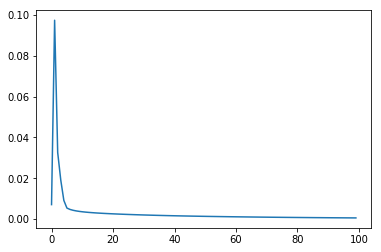

1


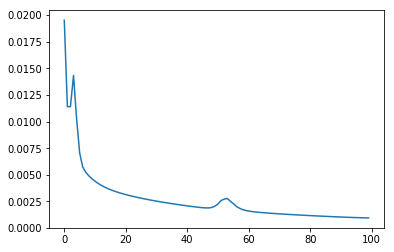

2


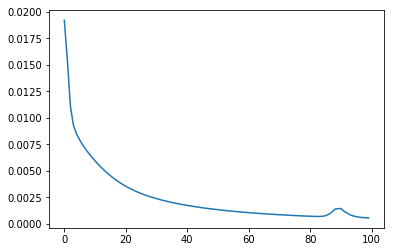

4


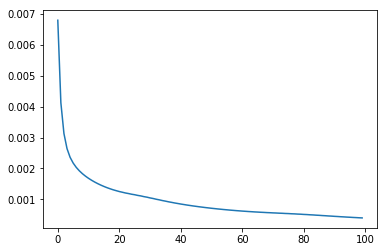

8


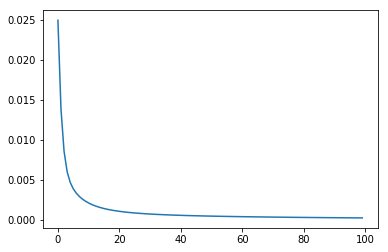

16


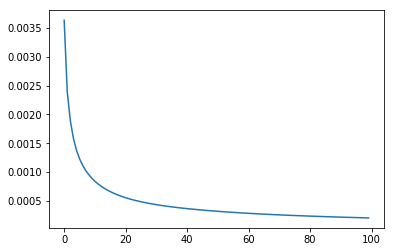

32


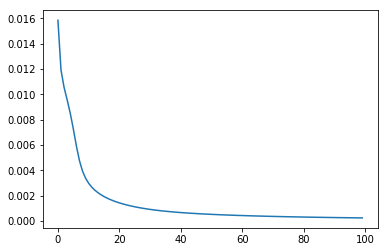

64


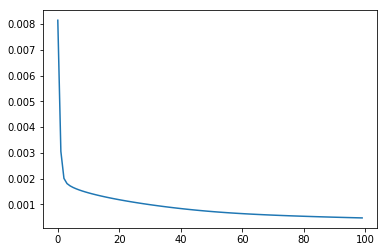

128


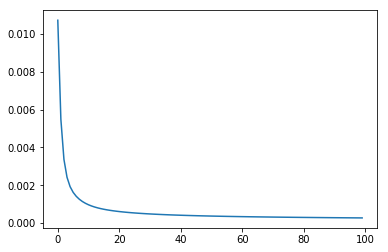

256


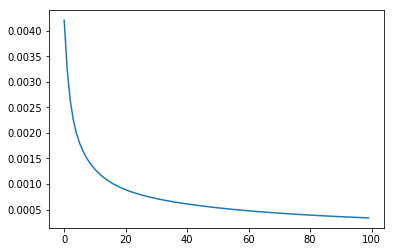

512


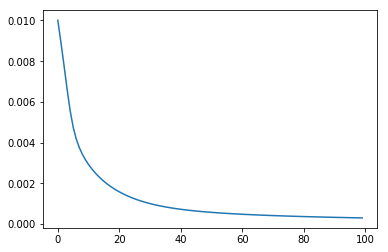

1024


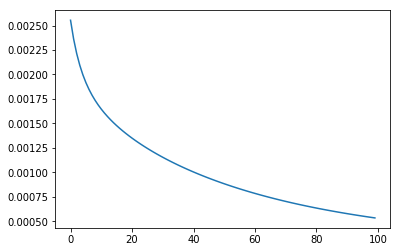

2048


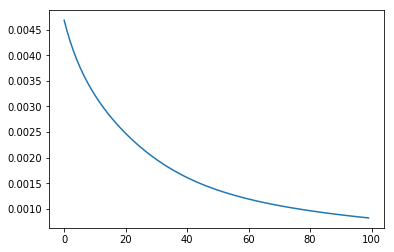

4096


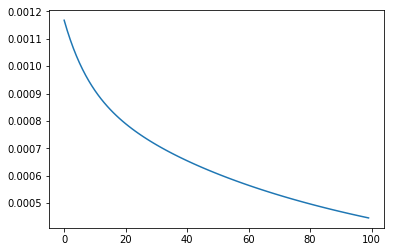

8192


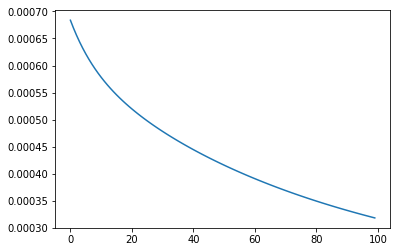

16384


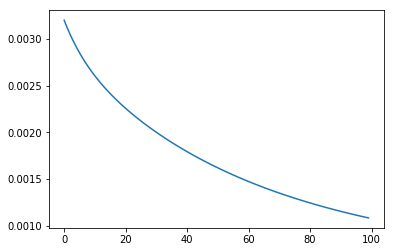

32768


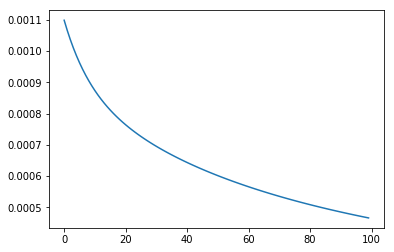

65536


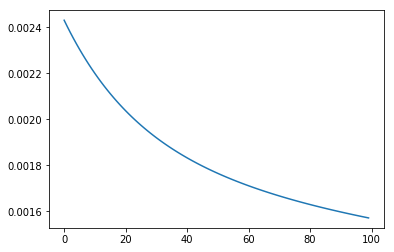


39709.252032995224 秒で学習完了。



先手での勝率: 0.363



後手での勝率: 0.688


In [3]:
import time
from datetime import datetime
from datetime import timedelta
from tqdm import tnrange
#v = vanillaAI() vはadagrad_with_single_300k.
games = 1000 #1000
loops = 100000 #20000
enemy = vanillaAI(filename="2nd_generation").move
print("先手での勝率:", sum([match(v.move, enemy, random_opening = 2) for i in tnrange(games)])/games)
print("後手での勝率:", 1-(sum([match(enemy, v.move, random_opening = 2) for i in tnrange(games)])/games))
v.deleteRecord()
t0 = time.time()
dt0 = datetime.now()
import matplotlib.pyplot as plt
for i in tnrange(loops):
    match(v.move, singleCalculationAI, random_opening=0)
    match(singleCalculationAI, v.move, random_opening=0)
    match(v.move, v.move, random_opening=0)
    l = v.learn(loops = 100, lr = 0.1, AdaGrad = True)
    if i in [0]+[2**j for j in range(20)]:
        print(i)
        plt.plot(l)
        plt.show()
print(time.time()-t0, "秒で学習完了。")
print("先手での勝率:", sum([match(v.move, enemy, random_opening = 2) for i in tnrange(games)])/games)
print("後手での勝率:", 1-(sum([match(enemy, v.move, random_opening = 2) for i in tnrange(games)])/games))
v.saveAI(filename="adagrad_with_single_300k", AdaGrad=True)

In [8]:
enemy = vanillaAI(filename="adagrad_with_single_300k").move#lambda m:singleCalculationAI(m)
games = 1000
print("先手での勝率:", sum([match(v.move, enemy, random_opening = 2) for i in tnrange(games)])/games)
print("後手での勝率:", 1-(sum([match(enemy, v.move, random_opening = 2) for i in tnrange(games)])/games))

先手での勝率: 0.484
後手での勝率: 0.496


In [29]:
print(sorted(v.h2[0], reverse=True))

[37.59799297676095, 36.3247969736734, 17.54290139420671, 11.916548382144903, 3.59151231367707, 3.1418457043916272, 2.9956561249163043, 1.8575907202535, 1.7309085439150338, 1.5591291382695667, 1.5359566250595298, 1.3154074451240692, 1.2616345441372778, 1.1251022256859222, 1.017177870855622, 0.9631692476923427, 0.9501131480575251, 0.762570056375331, 0.7079359439120795, 0.6998498306837257, 0.6252077119445909, 0.6195810012784668, 0.5954440126252614, 0.5670218919643538, 0.5409998397382471, 0.5029799956067419, 0.49287052562008477, 0.4525839324018782, 0.4235488349110784, 0.36336498514483595, 0.32259697212768923, 0.31655544027903015, 0.29571573630337694, 0.2952471129260868, 0.28576355220256855, 0.2666267951227898, 0.2342079201909528, 0.2272592827114079, 0.22177428573267358, 0.19764448622869382, 0.19265130376304399, 0.19116207169995583, 0.1666877423994085, 0.1638609587928934, 0.1428142989348106, 0.10086208495838055, 0.08723430348681961, 0.08479478312810228, 0.083386078809617, 0.0805054828551978

In [30]:
match(v.move, v.move, show=True)

Turn: 0
AI1
# # # # # # # # 
# x x X x x x # 
# x x x x x x # 
# . . . . . . # 
# . . o . . . # 
# o . o o o o # 
# o o o O o o # 
# # # # # # # # 
AI0

richJudge: 0
Turn: 1
AI1
# # # # # # # # 
# x x X x x x # 
# x x x x . x # 
# . . . x . . # 
# . . o . . . # 
# o . o o o o # 
# o o o O o o # 
# # # # # # # # 
AI0

richJudge: 0
Turn: 2
AI1
# # # # # # # # 
# x x X x x x # 
# x x x x . x # 
# . . . x . . # 
# . . o o . . # 
# o . o o . o # 
# o o o O o o # 
# # # # # # # # 
AI0

richJudge: 0
Turn: 3
AI1
# # # # # # # # 
# x x X x x x # 
# x . x x . x # 
# . . x x . . # 
# . . o o . . # 
# o . o o . o # 
# o o o O o o # 
# # # # # # # # 
AI0

richJudge: 0
Turn: 4
AI1
# # # # # # # # 
# x x X x x x # 
# x . x x . x # 
# . . x o . . # 
# . . . o . . # 
# o . o o . o # 
# o o o O o o # 
# # # # # # # # 
AI0

richJudge: 0
Turn: 5
AI1
# # # # # # # # 
# x x X x x x # 
# x . . x . x # 
# . . x x . . # 
# . . . o . . # 
# o . o o . o # 
# o o o O o o # 
# # # # # # # # 
AI0

richJudge: 0
Turn

True

In [6]:
play(AI=vanillaAI(filename="2nd_generation").move, humanfirst=True)

TURN 0
vanilla AI
# # # # # # # # 
# x x X x x x # 
# x x x x x x # 
# . . . . . . # 
# . . . . . . # 
# o o o o o o # 
# o o o O o o # 
# # # # # # # # 
Kazuki Ota

00 01 02 03 04 05 06 07 
08 09 10 11 12 13 14 15 
16 17 18 19 20 21 22 23 
24 25 26 27 28 29 30 31 
32 33 34 35 36 37 38 39 
40 41 42 43 44 45 46 47 
48 49 50 51 52 53 54 55 
56 57 58 59 60 61 62 63 

41 34
41.0 34.0
OK.
richJudge: 0
TURN 1
vanilla AI
# # # # # # # # 
# x x X x x x # 
# x x x x x x # 
# . . . . . . # 
# . o . . . . # 
# . o o o o o # 
# o o o O o o # 
# # # # # # # # 
Kazuki Ota

44.0 36.0
OK.
richJudge: 0
TURN 2
vanilla AI
# # # # # # # # 
# x x X x x x # 
# x x . x x x # 
# . . x . . . # 
# . o . . . . # 
# . o o o o o # 
# o o o O o o # 
# # # # # # # # 
Kazuki Ota

00 01 02 03 04 05 06 07 
08 09 10 11 12 13 14 15 
16 17 18 19 20 21 22 23 
24 25 26 27 28 29 30 31 
32 33 34 35 36 37 38 39 
40 41 42 43 44 45 46 47 
48 49 50 51 52 53 54 55 
56 57 58 59 60 61 62 63 

46 37
46.0 37.0
OK.
richJudge: 0
TURN 3


KeyboardInterrupt: 

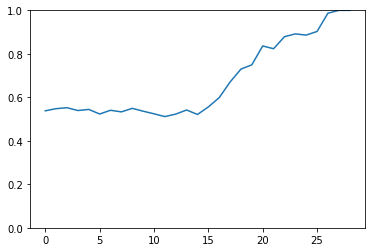

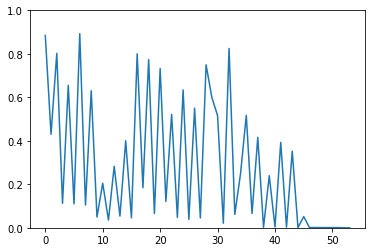

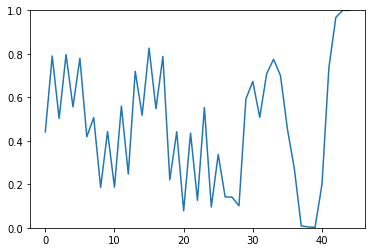

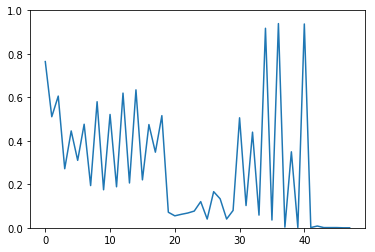

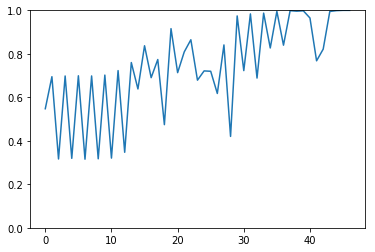

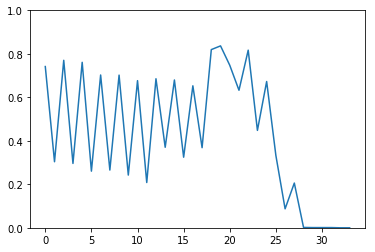

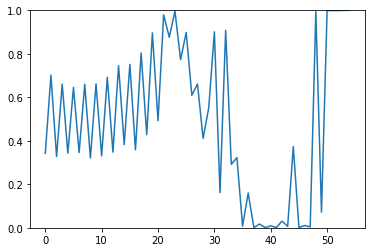

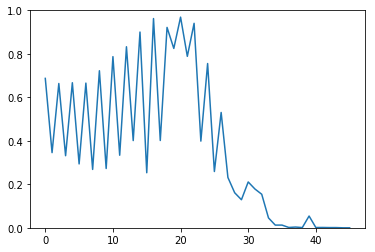

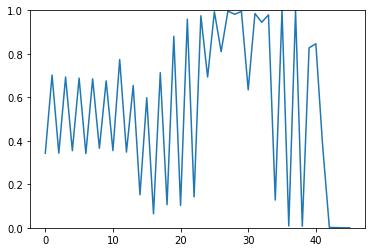

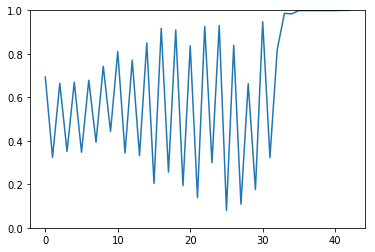

In [107]:
v = vanillaAI(filename="3rd_generation")
func = lambda m:v.move(m, showeval=False)
def test():
    match(func, func, show=False)
    plt.plot((np.arange(len(v.record_y))%2==1)+(-1)**np.arange(len(v.record_y))*np.array(v.record_y))
    plt.ylim(0,1)
    plt.show()
    l = v.learn(lr = 0.1, AdaGrad = True)
    #plt.plot(l)
    #plt.show()
for i in range(10):
    test()

# 0


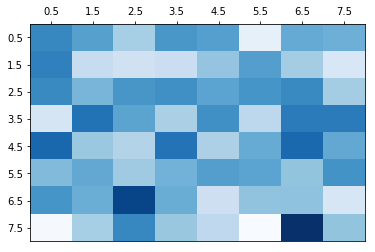

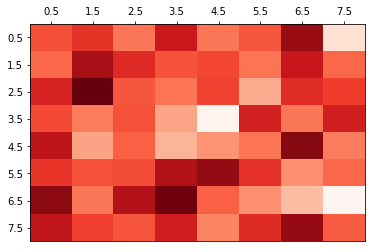

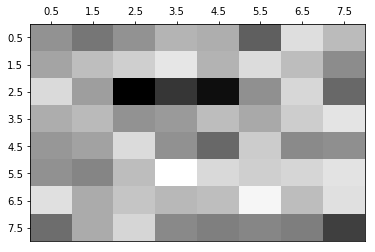

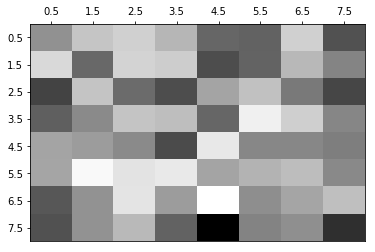

# 1


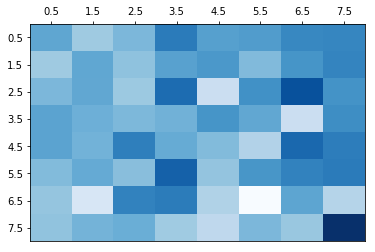

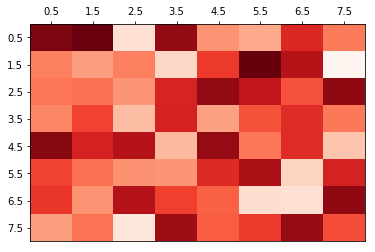

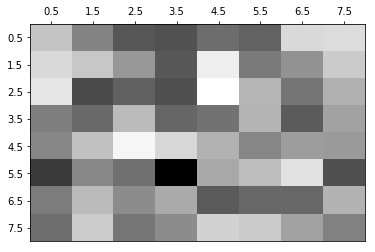

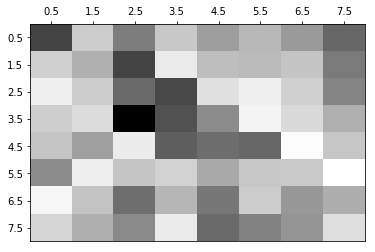

# 2


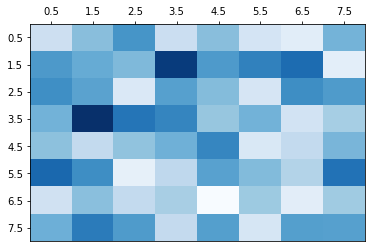

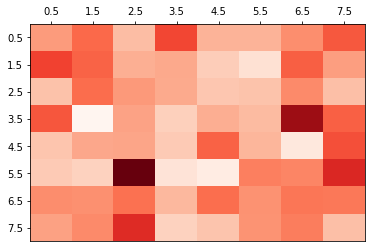

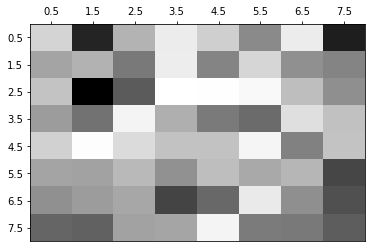

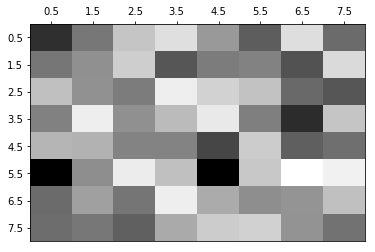

# 3


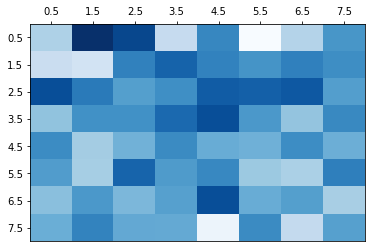

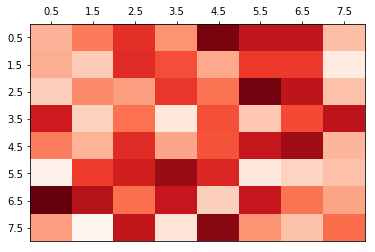

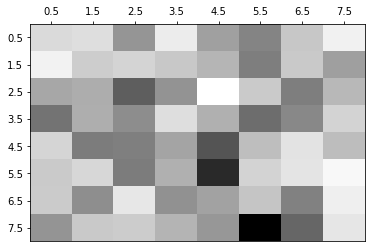

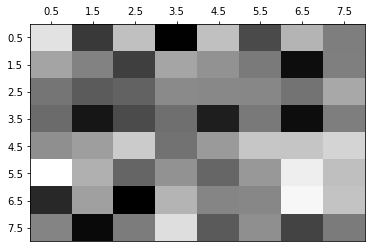

# 4


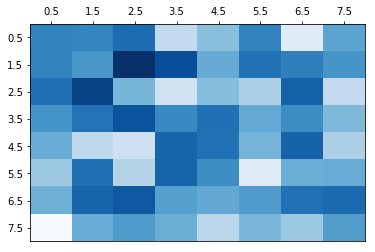

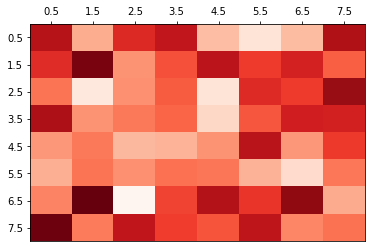

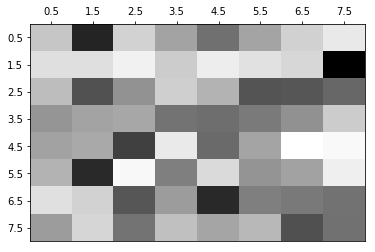

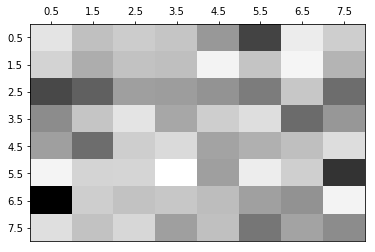

# 5


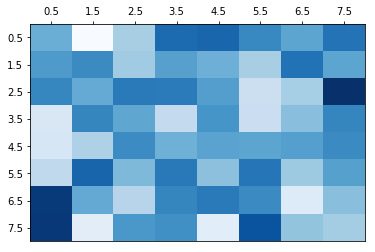

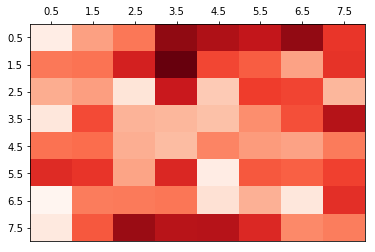

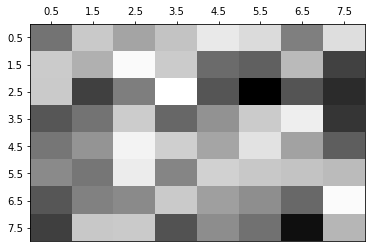

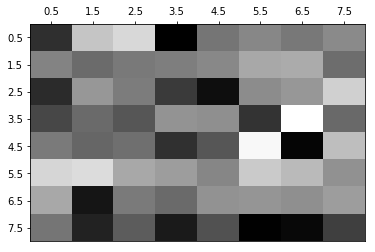

# 6


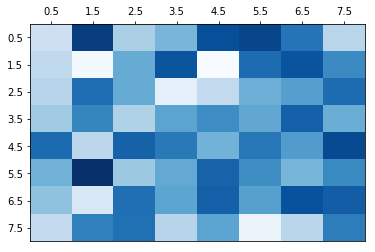

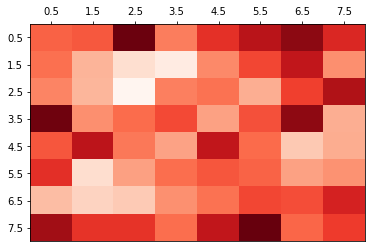

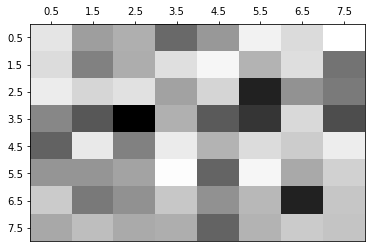

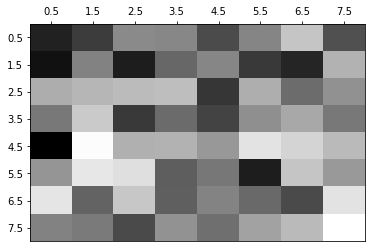

# 7


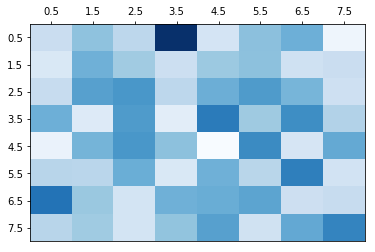

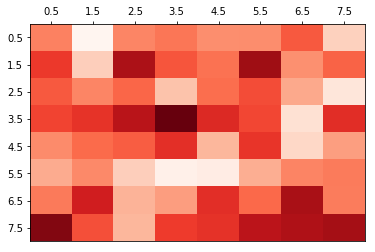

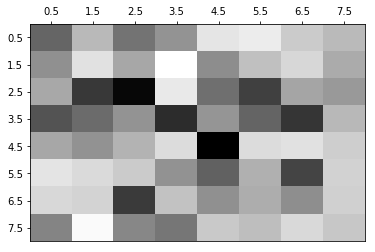

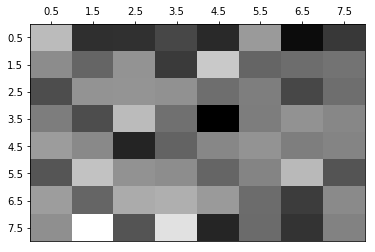

# 8


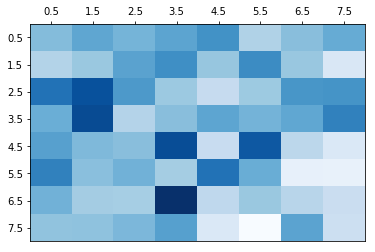

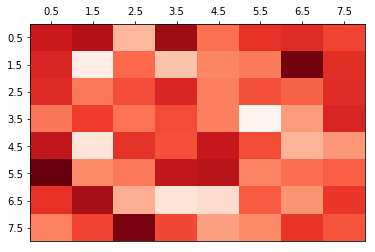

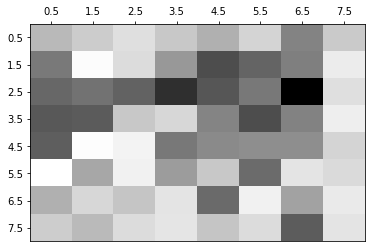

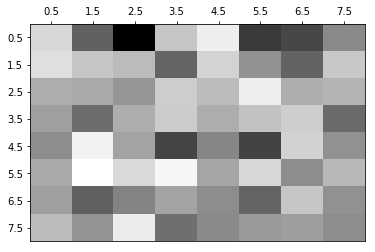

# 9


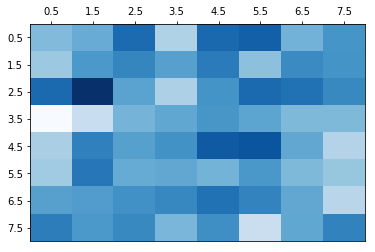

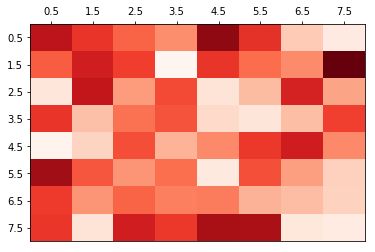

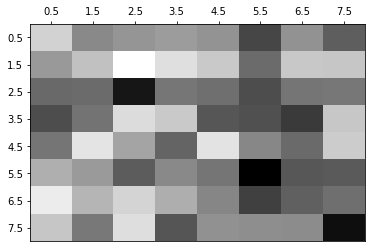

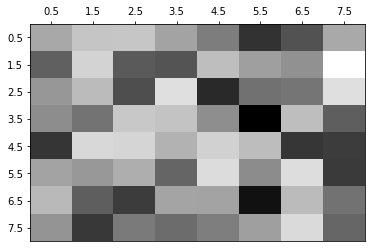

# 10


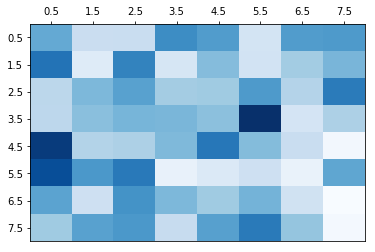

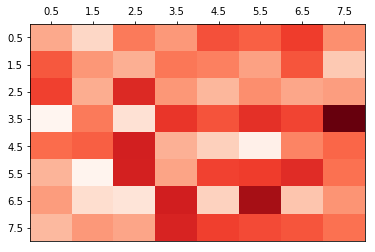

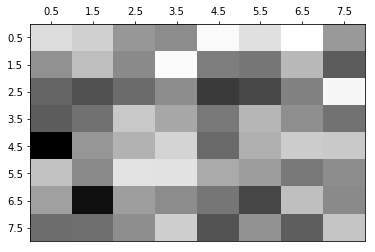

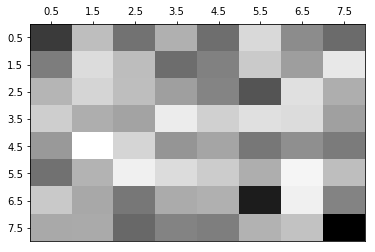

# 11


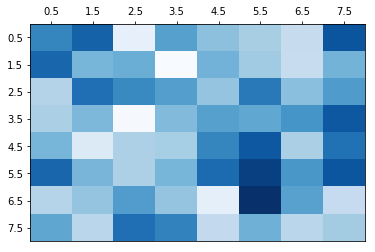

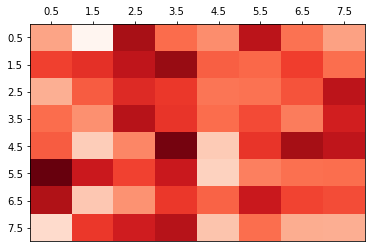

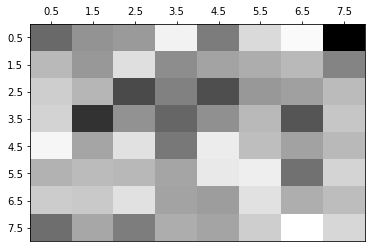

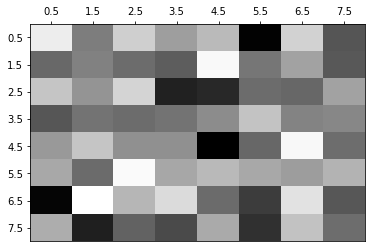

# 12


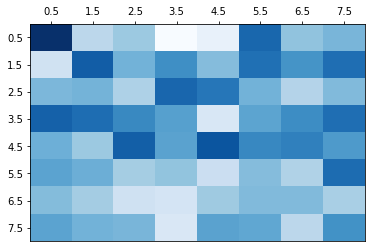

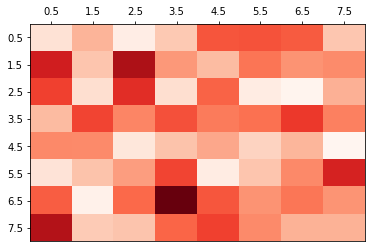

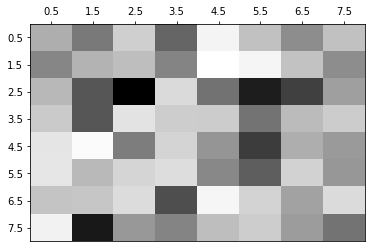

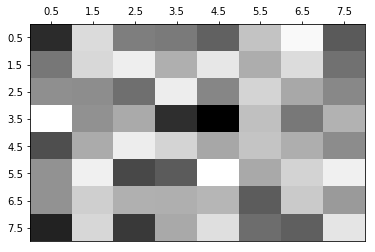

# 13


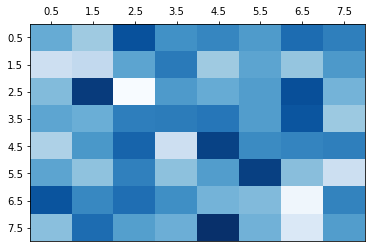

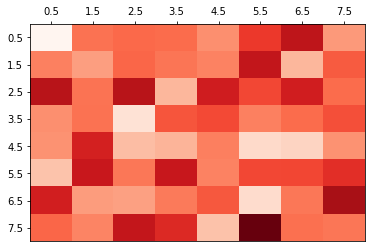

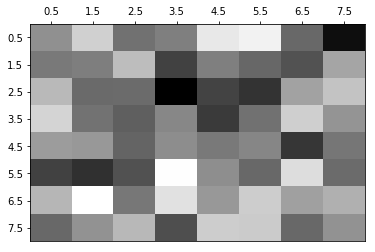

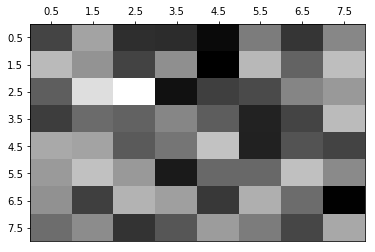

# 14


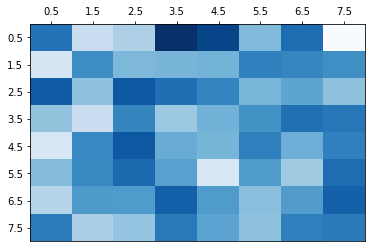

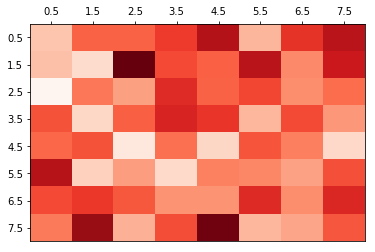

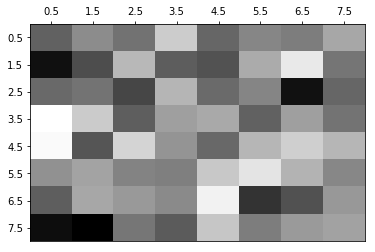

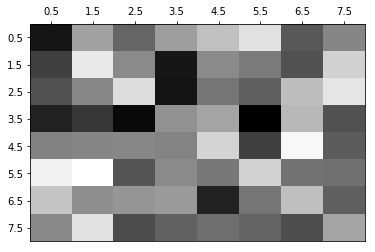

# 15


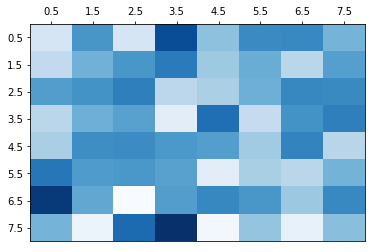

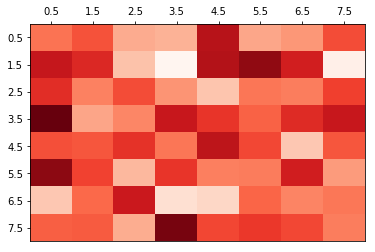

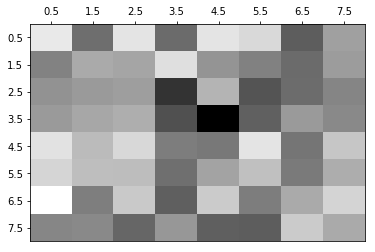

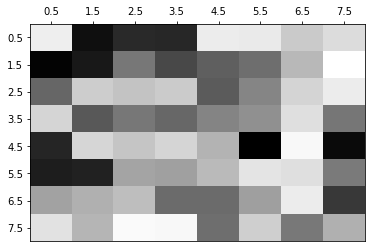

# 16


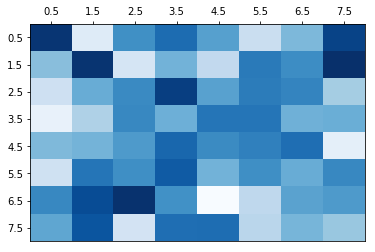

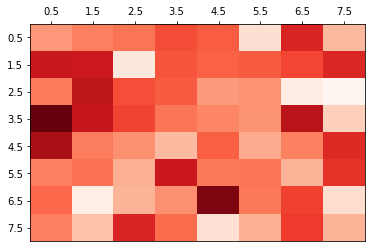

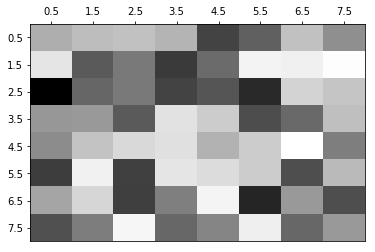

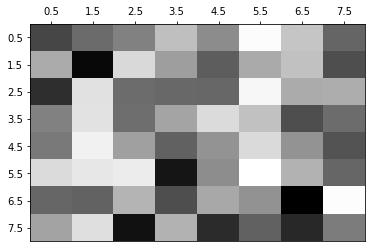

# 17


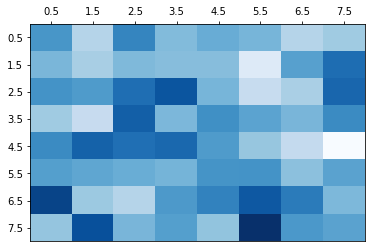

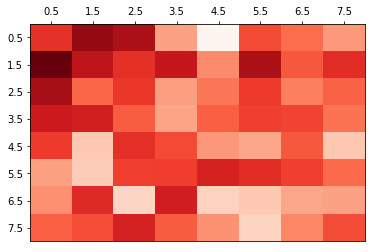

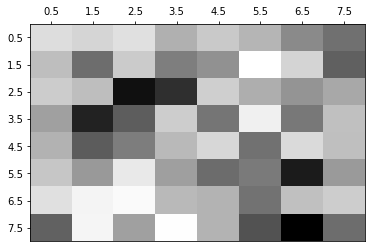

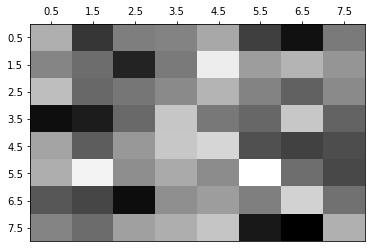

# 18


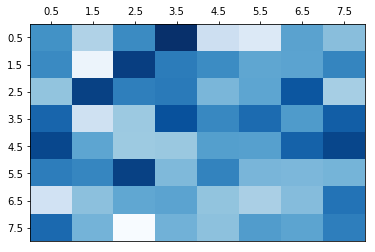

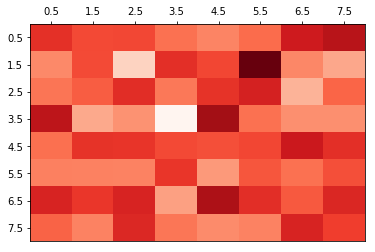

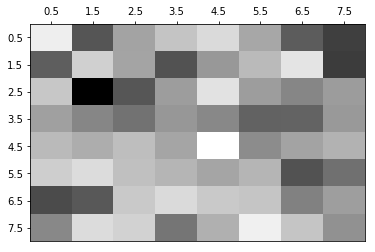

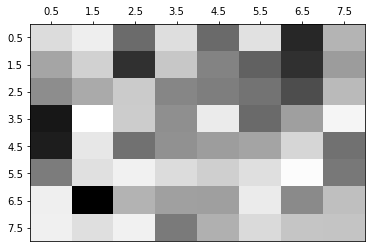

# 19


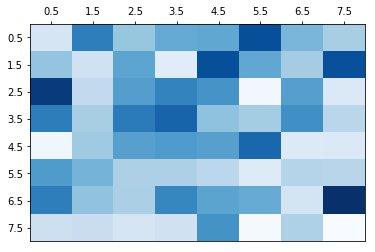

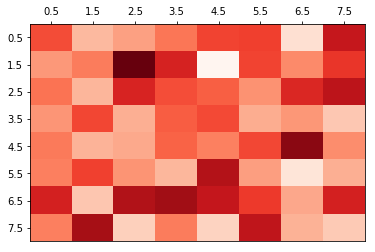

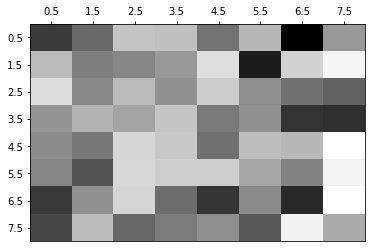

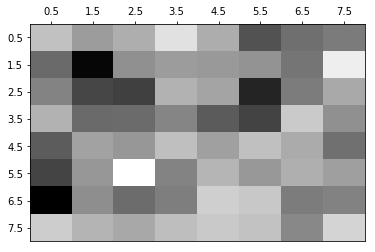

# 20


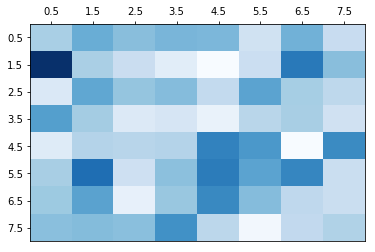

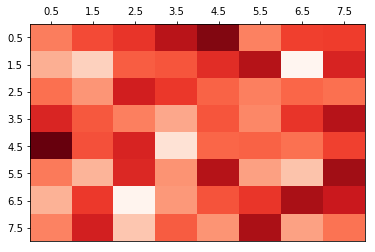

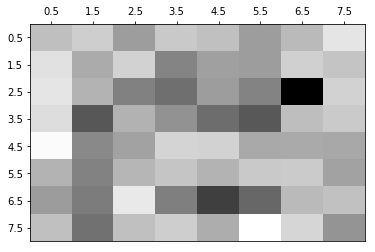

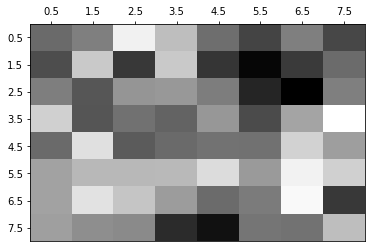

# 21


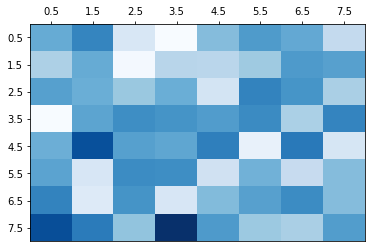

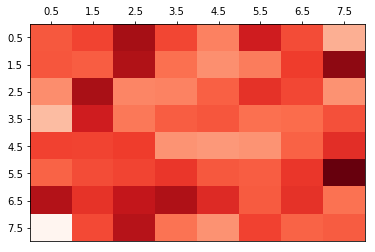

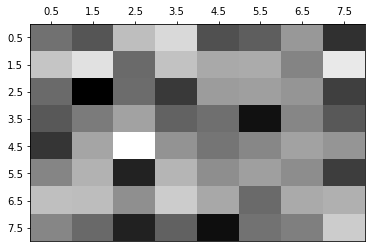

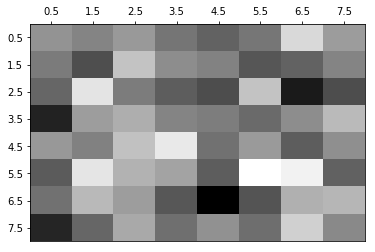

# 22


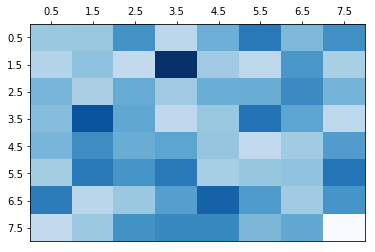

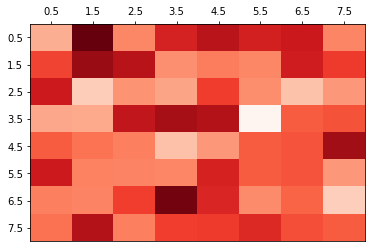

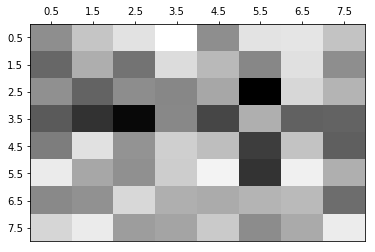

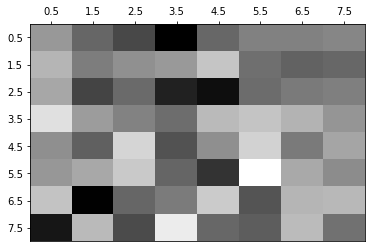

# 23


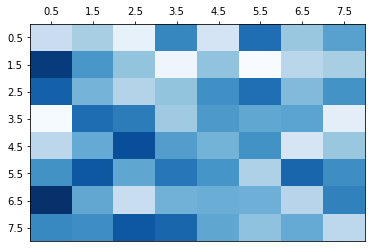

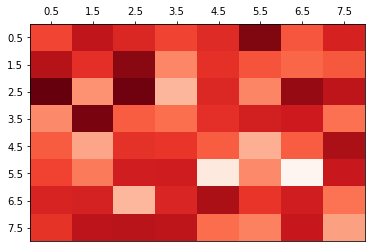

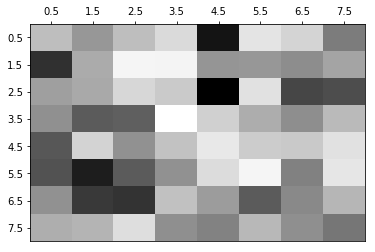

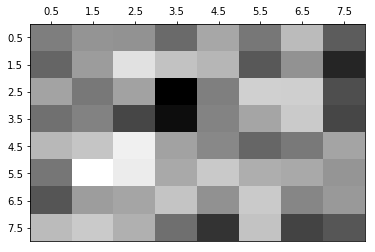

# 24


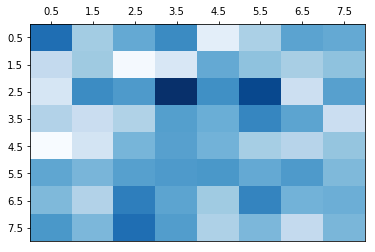

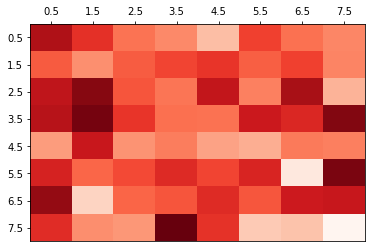

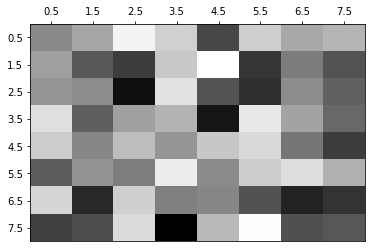

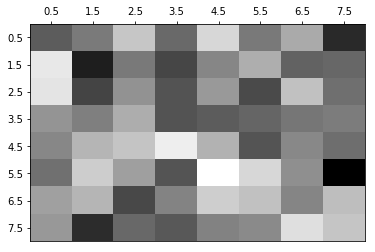

# 25


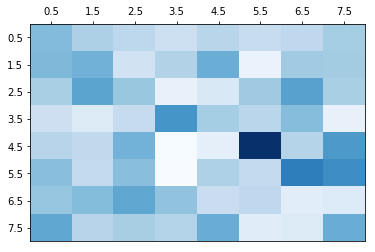

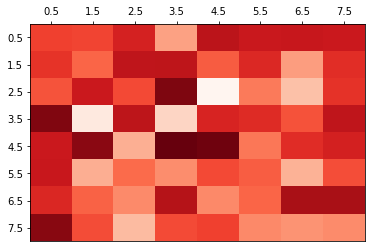

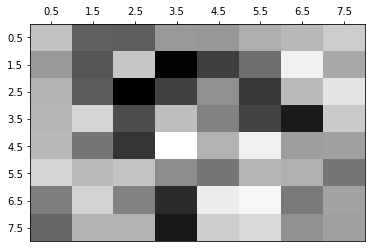

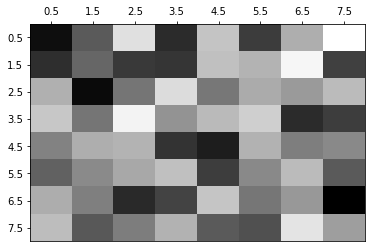

# 26


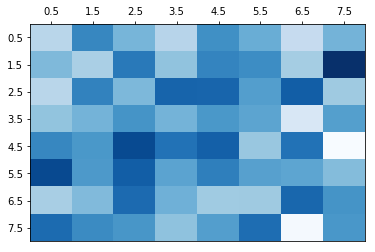

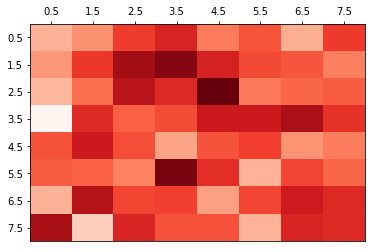

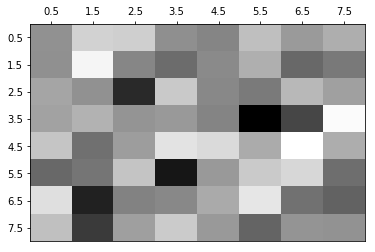

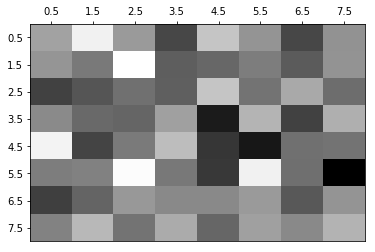

# 27


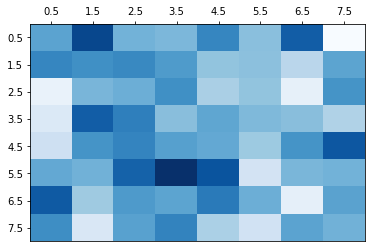

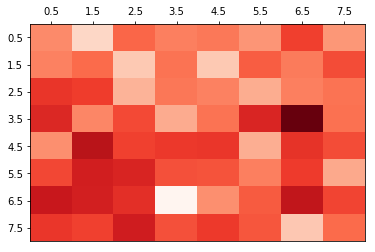

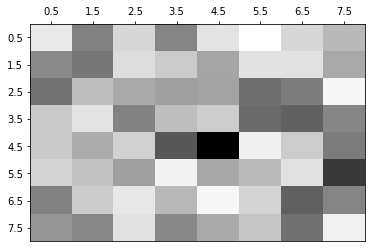

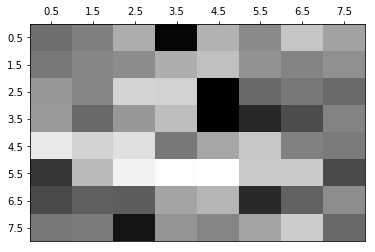

# 28


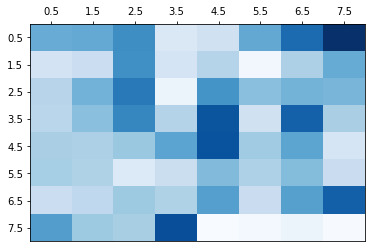

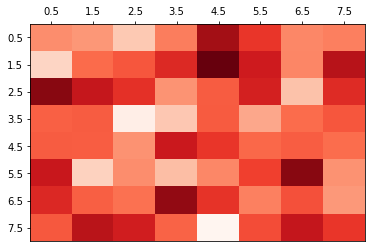

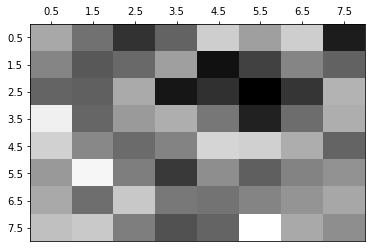

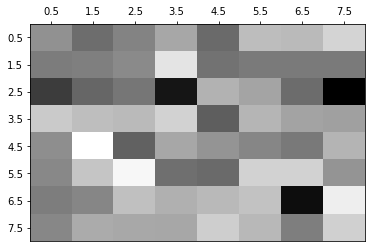

# 29


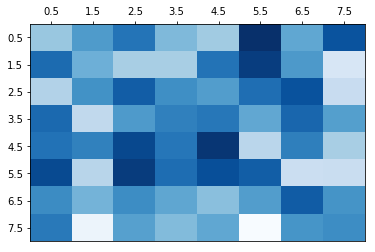

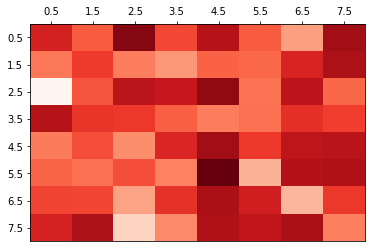

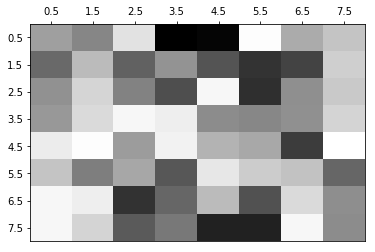

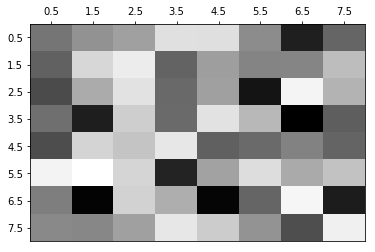

# 30


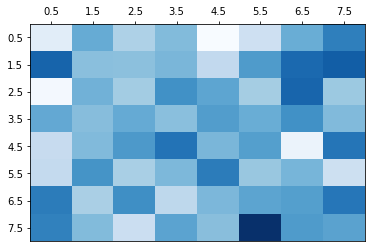

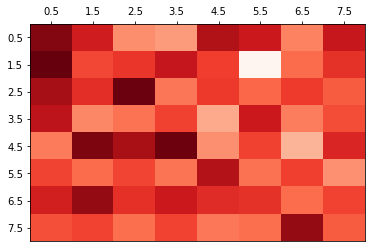

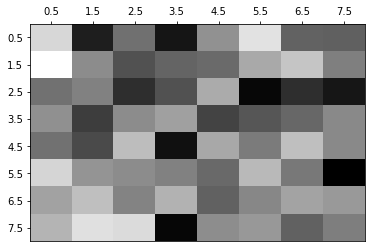

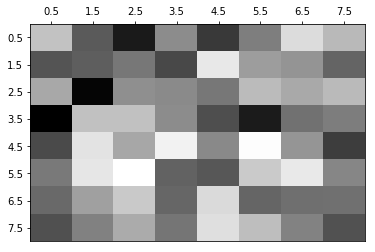

# 31


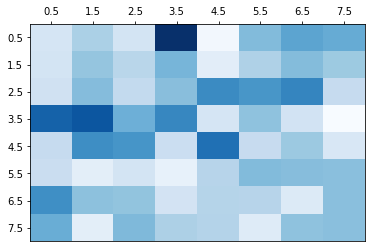

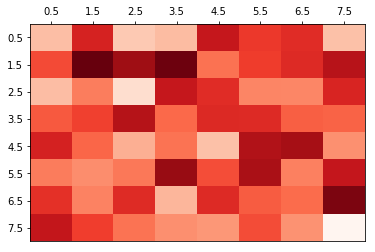

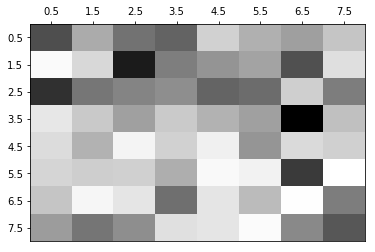

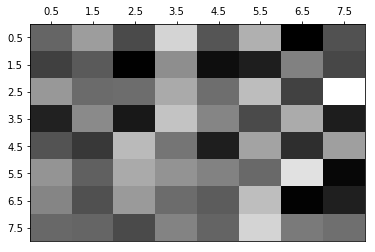

# 32


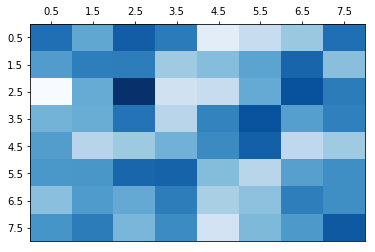

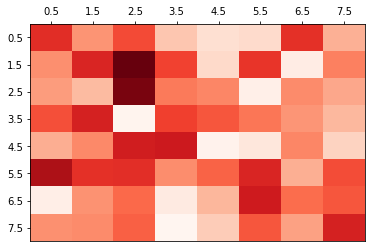

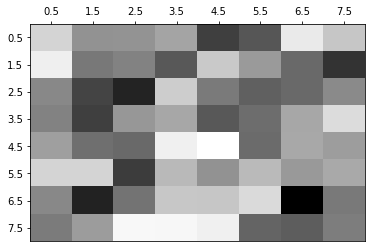

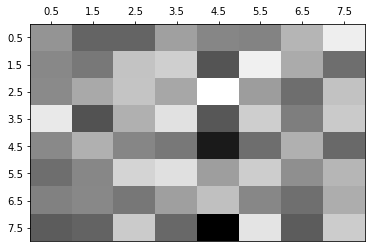

# 33


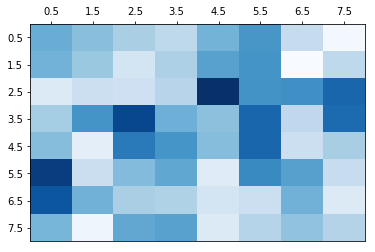

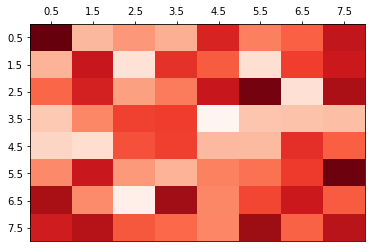

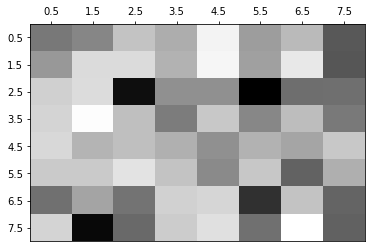

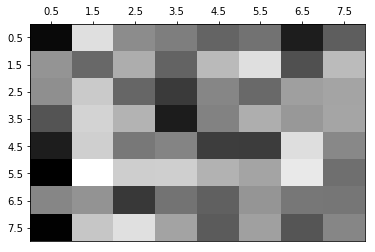

# 34


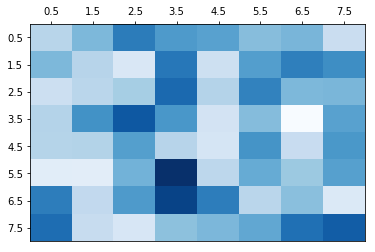

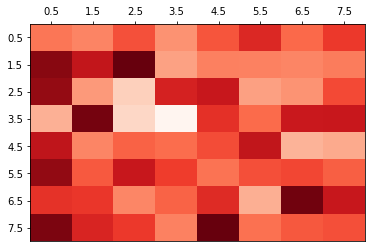

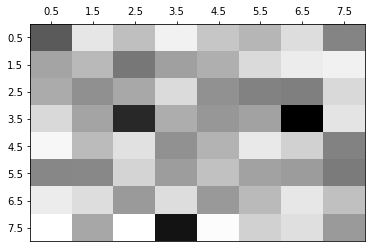

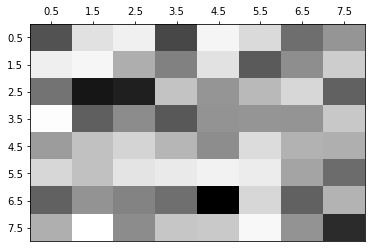

# 35


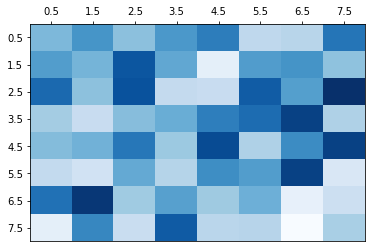

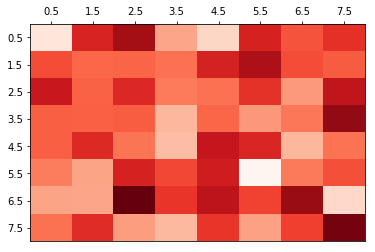

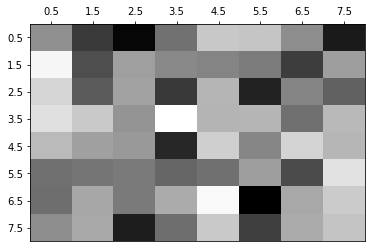

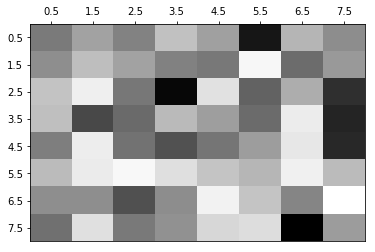

# 36


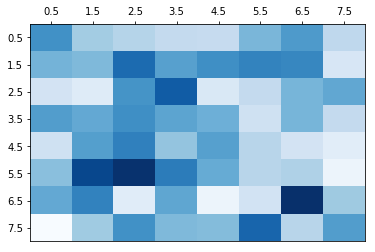

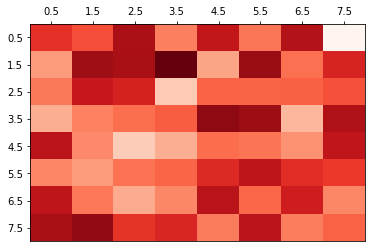

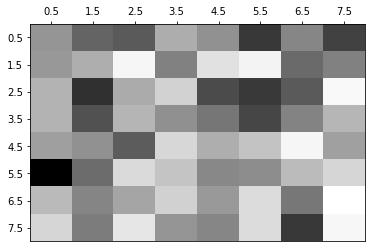

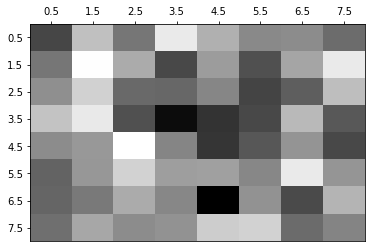

# 37


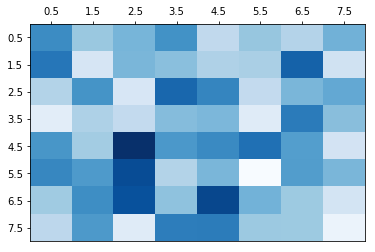

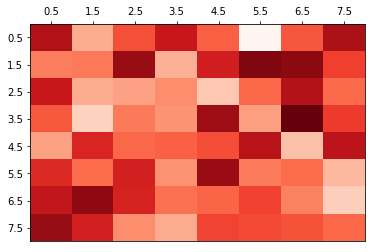

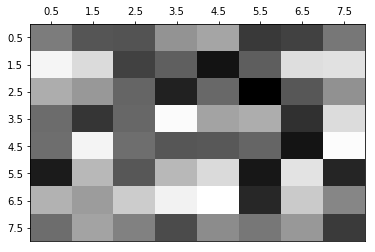

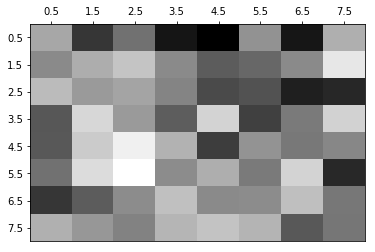

# 38


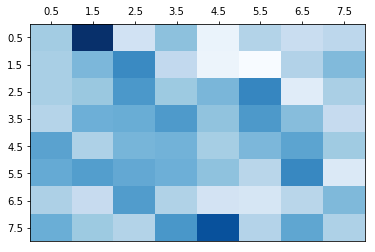

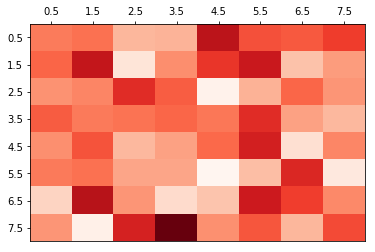

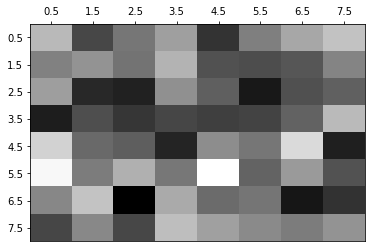

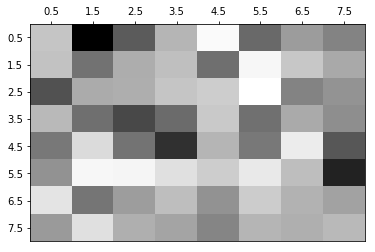

# 39


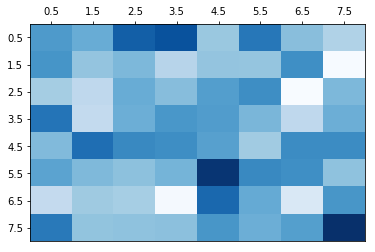

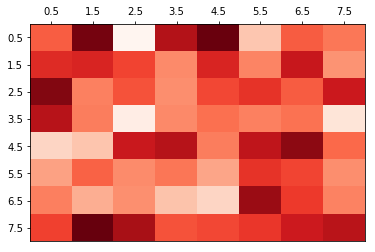

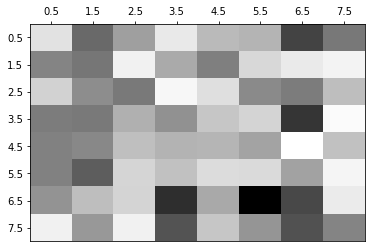

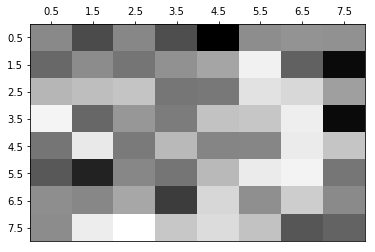

# 40


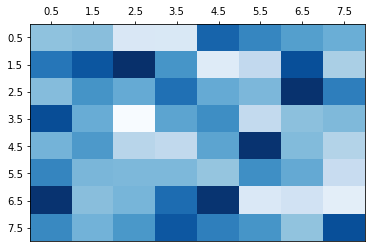

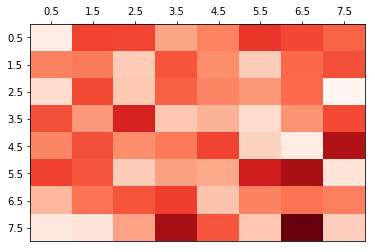

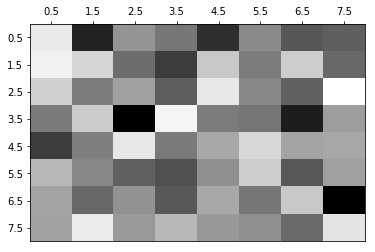

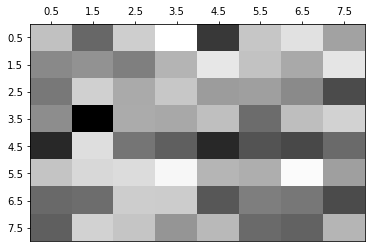

# 41


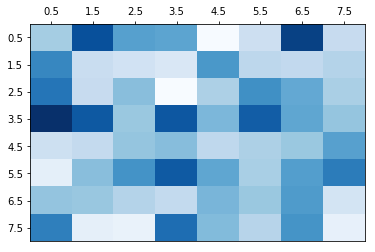

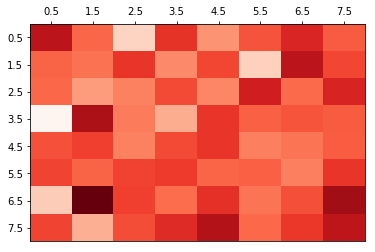

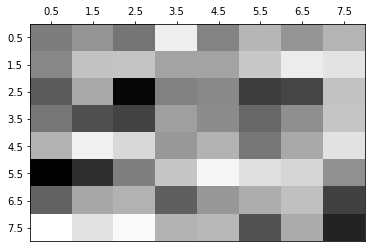

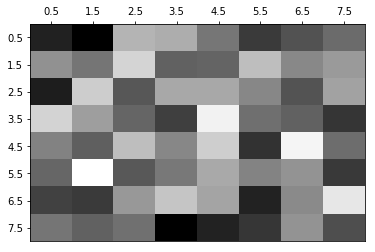

# 42


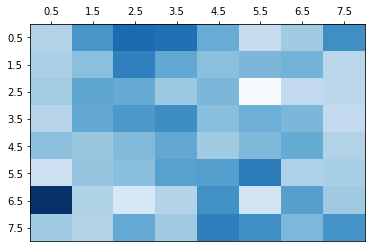

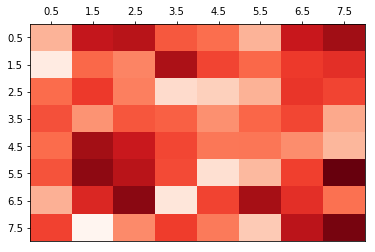

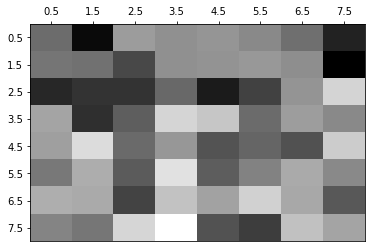

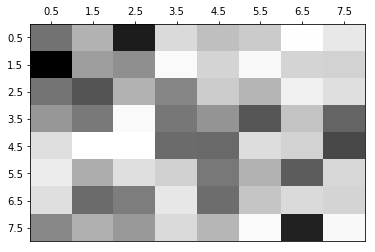

# 43


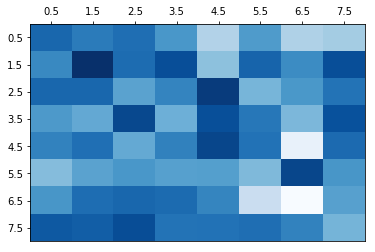

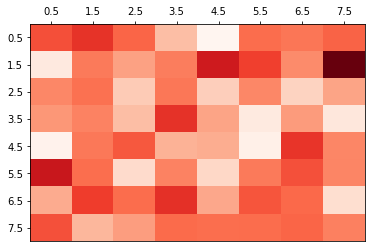

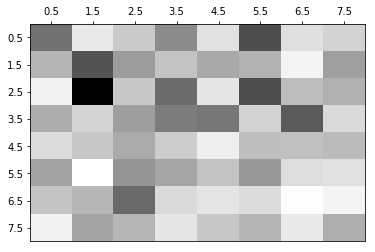

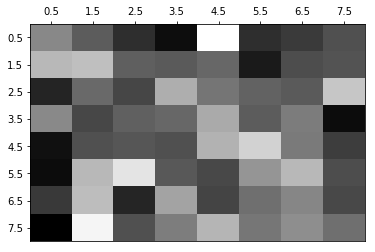

# 44


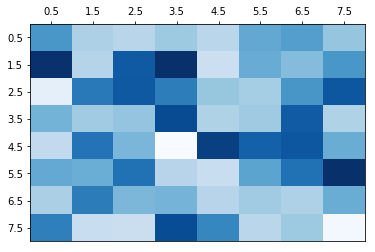

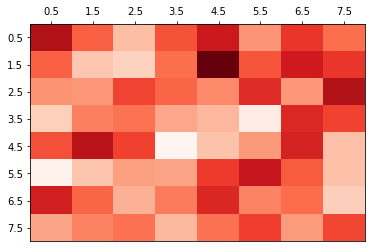

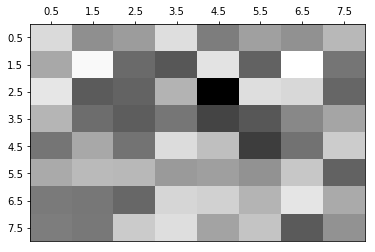

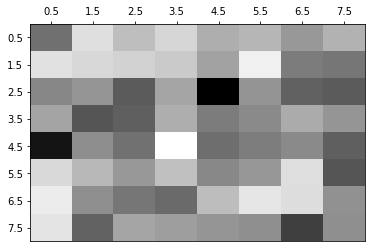

# 45


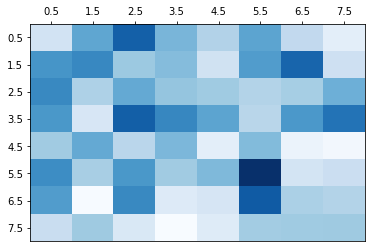

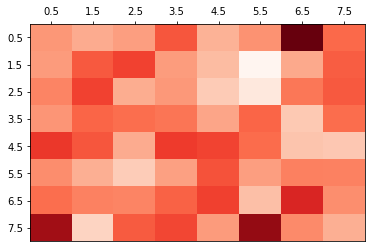

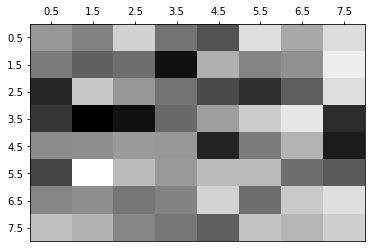

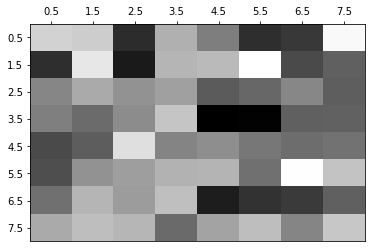

# 46


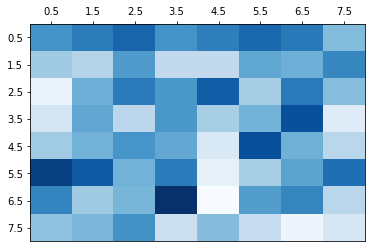

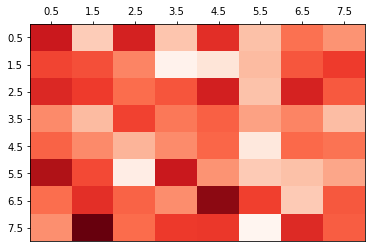

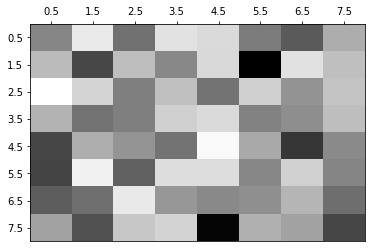

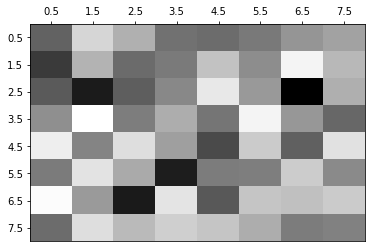

# 47


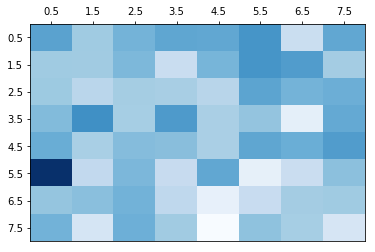

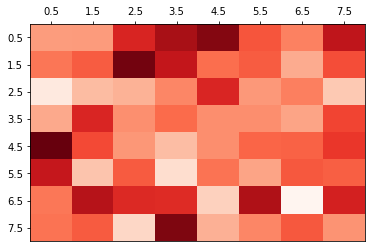

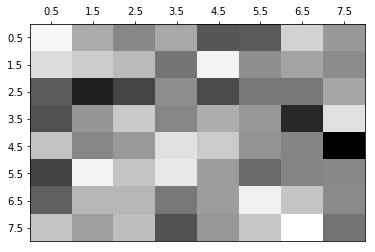

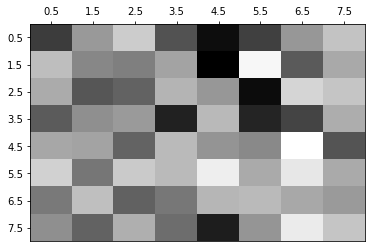

# 48


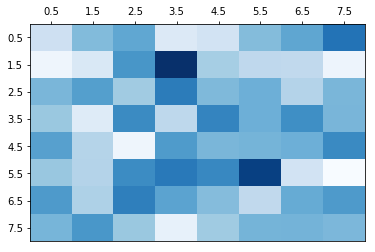

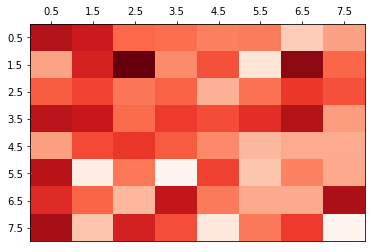

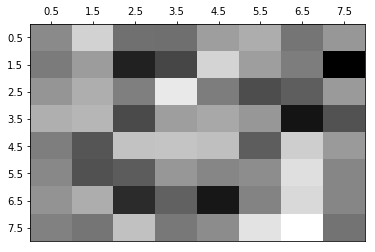

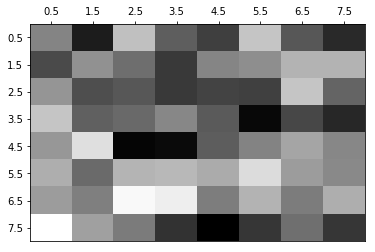

# 49


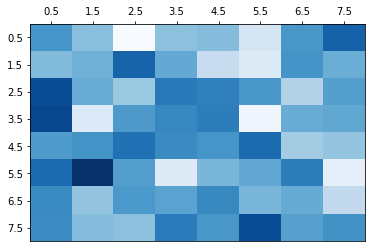

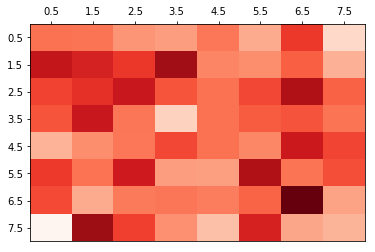

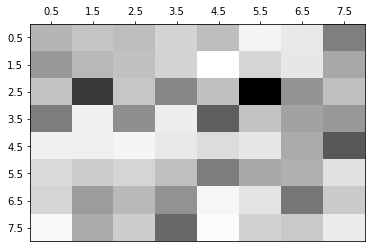

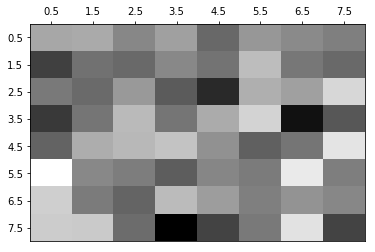

In [73]:
# 正方行列と X および Y のラベルの行列を渡す
def draw_heatmap(data, cmap, row_labels=None, column_labels=None):
    # 描画する
    fig, ax = plt.subplots()
    heatmap = ax.pcolor(data, cmap=cmap)

    ax.set_xticks(np.arange(data.shape[0]) + 0.5, minor=False)
    ax.set_yticks(np.arange(data.shape[1]) + 0.5, minor=False)

    ax.invert_yaxis()
    ax.xaxis.tick_top()
    if row_labels:
        ax.set_xticklabels(row_labels, minor=False)
    if column_labels:
        ax.set_yticklabels(column_labels, minor=False)
    plt.show()
W1 = v.W1
W2 = v.W2
#W1 = vanillaAI(filename="originalMix").W1
#W2 = vanillaAI(filename="originalMix").W2
for j in range(50):
    print("#",j)
    for i in range(4):
        draw_heatmap((W2[:,j]*W1[j,:]).reshape((4,8,8))[i], cmap = [plt.cm.Blues, plt.cm.Reds, plt.cm.Greys, plt.cm.Greys][i])